In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize

import petab
import numpy as np
from scipy.special import gammaln
from scipy.special import gamma
import pickle
from copy import deepcopy

datatype = "original"

# import to petab
if datatype == "original":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_original.yaml")
elif datatype == "switch":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_switch.yaml")
else:
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_loss .yaml")

In [2]:
def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k1, k2, _ = x
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

\begin{align*}
    p(D|\theta,\sigma)=& \int_0^\infty \frac{\lambda \cdot p(\sigma)}{2\sigma}  \Biggl(  e^{l_{r}/\sigma} \frac{\sigma}{N -2r - \sigma\lambda} \cdot \Biggl( \exp\biggl(b_{r + 1} \cdot \left(\frac{N - 2r}{\sigma} - \lambda\right)\biggr) - 1 \Biggr) \\
    &+ \sum_{i = r + 1}^{N-1} e^{l_i/\sigma} \frac{\sigma}{N - 2i - \sigma\lambda} \Biggl(\exp\biggl(b_{i + 1} \cdot \left(\frac{N - 2i}{\sigma} - \lambda\right)\biggr) - \exp\biggl(b_i \cdot \left(\frac{N - 2i}{\sigma} - \lambda\right)\biggr) \Biggr) \\
    &+ e^{l_N/\sigma} \frac{\sigma}{N + \sigma\lambda} \exp\biggl(b_N \cdot \left(\frac{-N}{\sigma} - \lambda\right)\biggr) \Biggr) d\sigma
 \end{align*}

In [3]:
def negative_log_marginalised_likelihood(x):
    scale = x[2]
    
    data = np.asarray(petab_problem.measurement_df.measurement)
    tvec = np.asarray(petab_problem.measurement_df.time)
    N = len(tvec)
    
    # simulate model
    _simulation = simulate_model(np.exp(x), tvec)
    simulation = np.asarray(_simulation)
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    r = np.argmax(bounds >= 0)-1
    
    marginal_posterior = 0
    for n in range(len(bounds)-1):
        l_value = np.sum(b_vector[:n]) - np.sum(b_vector[n:])
        tmp = l_value/scale
        if n < r:
            aux1 = scale/(N-2*r-scale*lamda)
            aux2 = (np.exp(tmp+bounds[r]*((N-2*r)/scale-lamda))-np.exp(tmp))

        elif n == len(bounds)-2:
            aux1 = scale/(N+scale*lamda)
            aux2 = np.exp(tmp+bounds[n]*(-N/scale-lamda))

        else:
            aux = (N-2*n)/scale-lamda
            aux1 = scale/(N-2*n-scale*lamda)
            aux2 = np.exp(tmp+bounds[n+1]*aux)-np.exp(tmp+bounds[n]*aux)
        
        marginal_posterior += aux1*aux2
        
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += N*(- np.log(2) -np.log(scale))+np.log(lamda) 
    
    return -log_marginal_posterior

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [4]:
def marginal_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_marginalised_likelihood)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-5, -5, 0],  # lower bounds
                              ub=[5, 5, np.inf],  # upper bounds
                              x_names=['k1', 'k2', 'scale'],  # parameter names
                              x_scales=['log', 'log', 'lin'])  # parameter scale
    return problem

In [5]:
### Prior dependent paramters

lamda = 0.01

# create the estimation problem
problem = marginal_sampling()

# MCMC chain length
n_samples= 10000

# call the sampler of choice
sampler = sample.AdaptiveMetropolisSampler()

x0=np.array([-1.2741, -0.6160, 0.3684])

Now we can perform the actual sampling.

In [6]:
# Define number of runs
runs = 1

save_results = False # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = [result.sample_result, 'LP_CR_OM']
        with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 10000/10000 [00:06<00:00, 1460.65it/s]


There are some built-in visualization functions that one can use.

603.0755603445042
87.7318922591136


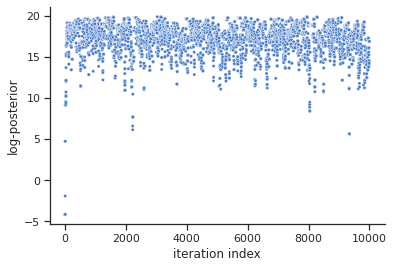

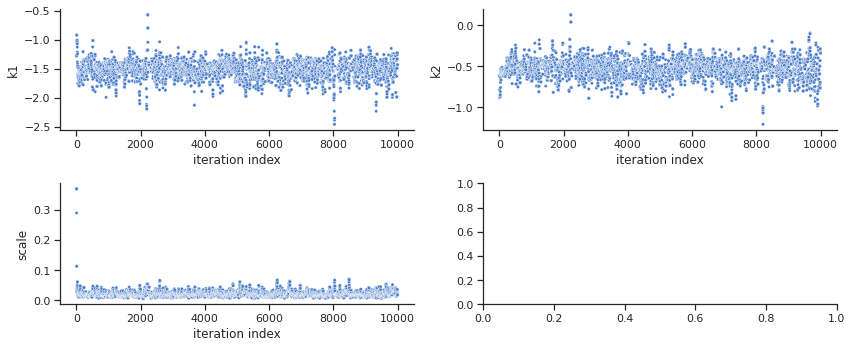

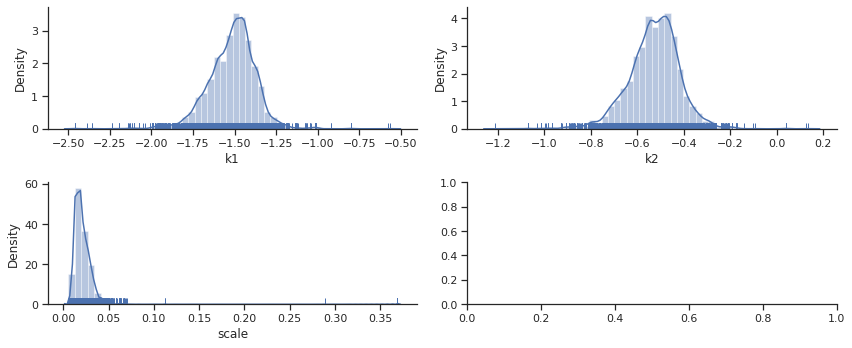

In [8]:
print(result.sample_result.effective_sample_size)
print(result.sample_result.effective_sample_size/result.sample_result.time)
ax = visualize.sampling_fval_traces(result,full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))